
Generating IID samples from the trimodal posterior...


Generating IID samples from the trimodal posterior...



/home/fabian/anaconda3/envs/pymc_immo_env/lib/python3.12/site-packages/pytensor/tensor/rewriting/math.py:2397: RuntimeWarning: invalid value encountered in scalar subtract
  v = reduce(np.add, num, zero) - reduce(np.add, denum, zero)
Multiprocess sampling (10 chains in 4 jobs)
CompoundStep
>Metropolis: [w]
>Metropolis: [mixed_normal]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 4 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


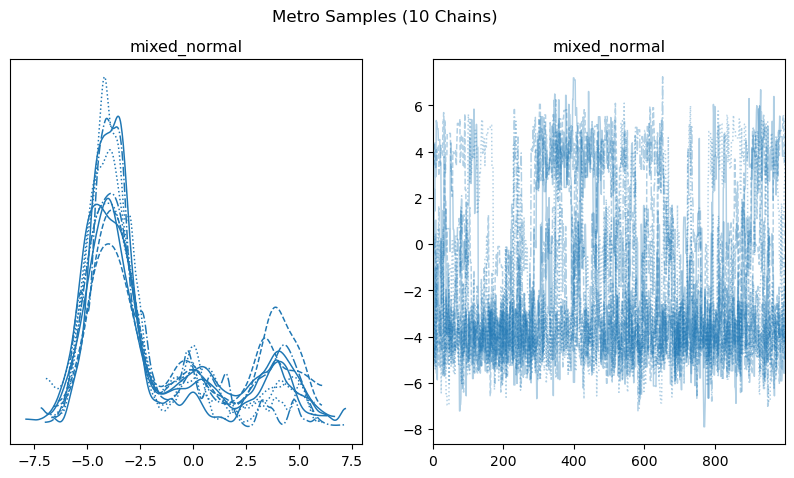

Metro: Wasserstein Distance = 0.2286
Metro: R-hat value = 1.0356


Multiprocess sampling (10 chains in 4 jobs)
NUTS: [w, mixed_normal]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


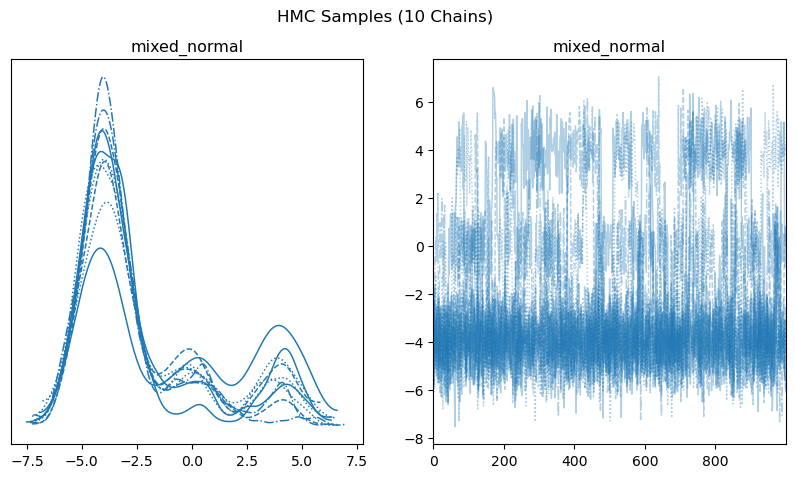

HMC: Wasserstein Distance = 0.0851
HMC: R-hat value = 1.0394


Population sampling (10 chains)
DEMetropolis: [w, mixed_normal]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Output()

Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


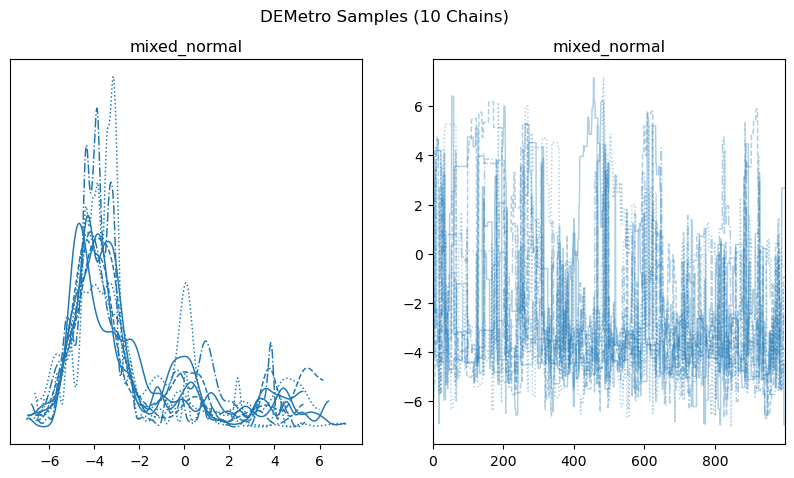

DEMetro: Wasserstein Distance = 0.2166
DEMetro: R-hat value = 1.0327

### Ranked Sampler Performance ###
1. HMC: 0.0851
2. DEMetro: 0.2166
3. Metro: 0.2286

### Ranked Sampler R-hat Values ###
1. DEMetro: 1.0327
2. Metro: 1.0356
3. HMC: 1.0394


In [45]:
import numpy as np
import pymc as pm
import arviz as az
import scipy.stats as sp
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


class WassersteinExample:
    
    def __init__(self, weights=[1,1], posterior_type="bimodal"):
        self.posterior_type = posterior_type
        self.model, self.means, self.weights = self._define_posterior(weights, posterior_type)
    
    def _define_posterior(self, weights, posterior_type):        
        with pm.Model() as model:
            
            if posterior_type == "bimodal":
                means = [8, -8]
            elif posterior_type == "bimodal_far":
                means = [15, -15]
            elif posterior_type == "trimodal":
                means = [-4, 0, 4]
                weights = [5, 1, 1]  
            elif posterior_type == "trimodal_far":
                means = [-15, 0, 15]
                weights = [5, 1, 1]  
            elif posterior_type == "cauchy":
                return self._cauchy_model(), None, None
            else:
                raise ValueError(f"Unknown posterior type: {posterior_type}")
            
            weights = np.array(weights) / np.sum(weights)
            w = pm.Dirichlet("w", a=np.array(weights))
            mu = pm.Normal.dist(means, 1)
            mixed_normal = pm.Mixture("mixed_normal", w=w, comp_dists=mu)
        
        return model, means, weights
    
    def _cauchy_model(self):
        with pm.Model() as model:
            cauchy_dist = pm.Cauchy("cauchy", alpha=0, beta=1)
        return model
    
    def generate_iid_samples(self, num_samples=2000):
        print(f"\nGenerating IID samples from the {self.posterior_type} posterior...\n")
        
        if self.posterior_type == "cauchy":
            #return np.random.standard_cauchy(size=num_samples)
            alpha = 0    
            beta = 2     
            return alpha + beta * np.random.standard_cauchy(size=num_samples)

        else:
            modes = np.random.choice(self.means, size=num_samples, p=self.weights)
            return np.random.normal(loc=modes, scale=1, size=num_samples)
    
    def run_sampling(self, sampler_name, num_samples=2000, tune=1000, num_chains=2, initvals=None):
        with self.model:
            if sampler_name == "Metro":
                sampler = pm.Metropolis()
            elif sampler_name == "HMC":
                sampler = pm.NUTS()
            elif sampler_name == "DEMetro":
                sampler = pm.DEMetropolis()
            else:
                raise ValueError(f"Unknown sampler: {sampler_name}")
            
            trace = pm.sample(num_samples, tune=tune, step=sampler, initvals=initvals,
                              chains=num_chains, return_inferencedata=True, progressbar=True)
            
            az.plot_trace(trace, var_names=["mixed_normal" if self.posterior_type != "cauchy" else "cauchy"], figsize=(10, 5))
            plt.suptitle(f"{sampler_name} Samples ({num_chains} Chains)")
            plt.show()
        
        return trace
    
    def compute_wasserstein_distances(self, trace, iid_samples):
        if self.posterior_type == "cauchy":
            sampled_values = trace.posterior["cauchy"].values.flatten()
        else:
            sampled_values = trace.posterior["mixed_normal"].values.flatten()
        
        return sp.wasserstein_distance(sampled_values, iid_samples)


# Example usage
# options: "bimodal", "bimodal_far", "trimodal", "cauchy"
posterior_type = "trimodal"  # Change this to try different posteriors
num_samples = 10000
num_chains = 10
samples_per_chain = num_samples // num_chains

framework = WassersteinExample(weights=[4, 1], posterior_type=posterior_type)
iid_samples = framework.generate_iid_samples(num_samples=num_samples)

# Generate IID samples (assuming your framework has already provided them)
iid_samples = framework.generate_iid_samples(num_samples=num_samples)

ws_results = {}
traces = {}
r_hat_values = {}

for sampler_name in ["Metro", "HMC", "DEMetro"]:
    trace = framework.run_sampling(sampler_name, num_samples=samples_per_chain, num_chains=num_chains)
    
    # Computation of Wasserstein distance
    ws_distance = framework.compute_wasserstein_distances(trace, iid_samples)
    ws_results[sampler_name] = ws_distance

   # Compute R-hat only on the selected variable
    var_name = "mixed_normal" if framework.posterior_type != "cauchy" else "cauchy"
    r_hat = az.rhat(trace)  
    r_hat_value = r_hat[var_name].values.item()  
    r_hat_values[sampler_name] = r_hat_value
    
    traces[sampler_name] = trace
    print(f"{sampler_name}: Wasserstein Distance = {ws_distance:.4f}")
    print(f"{sampler_name}: R-hat value = {r_hat_value:.4f}")

# Ranked results
print("\n### Ranked Sampler Performance ###")
for rank, (sampler_name, ws_distance) in enumerate(sorted(ws_results.items(), key=lambda x: x[1]), 1):
    print(f"{rank}. {sampler_name}: {ws_distance:.4f}")

print("\n### Ranked Sampler R-hat Values ###")
for rank, (sampler_name, r_hat) in enumerate(sorted(r_hat_values.items(), key=lambda x: x[1]), 1):
    print(f"{rank}. {sampler_name}: {r_hat:.4f}")


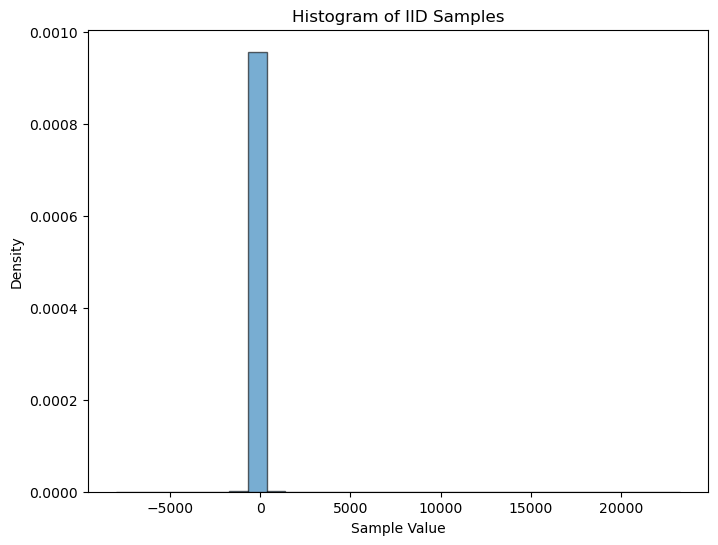

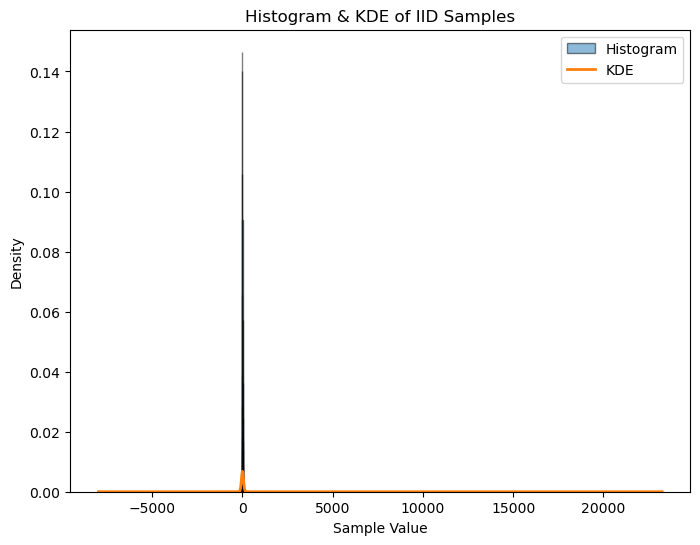

In [41]:
bin_edges = np.arange(-4, 4, 0.6)  # Bins every 0.2 units


# Plot histogram
plt.figure(figsize=(8, 6))
#plt.hist(iid_samples, bins=bin_edges, density=True, alpha=0.6, edgecolor='black')
plt.hist(iid_samples, bins=30, density=True, alpha=0.6, edgecolor='black')
# Add labels and title
plt.xlabel("Sample Value")
plt.ylabel("Density")
plt.title("Histogram of IID Samples")

# Show plot
plt.show()


# Compute KDE
kde = gaussian_kde(iid_samples, bw_method=0.2)  # Adjust bw_method for smoothness
x_values = np.linspace(np.min(iid_samples), np.max(iid_samples), 1000)
kde_values = kde(x_values)

# Plot histogram & KDE
plt.figure(figsize=(8, 6))
plt.hist(iid_samples, bins=30000, density=True, alpha=0.5, edgecolor='black', label="Histogram")
plt.plot(x_values, kde_values, label="KDE", linewidth=2)

# Labels & legend
plt.xlabel("Sample Value")
plt.ylabel("Density")
plt.title("Histogram & KDE of IID Samples")
plt.legend()

# Show plot
plt.show()
